<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/Gold_price_Tme_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
data_pd=pd.read_csv("/content/Gold_Prices.csv")

In [3]:
data_pd.head()

,Day,price
0,1,226.00
1,2,226.00
2,3,226.80
3,4,218.60
4,5,223.15


In [36]:
data_np=data_pd.to_numpy()

In [37]:
data_np

array([[1.00000e+00, 2.26000e+02],
       [2.00000e+00, 2.26000e+02],
       [3.00000e+00, 2.26800e+02],
       ...,
       [1.08790e+04, 1.94720e+03],
       [1.08800e+04, 1.96625e+03],
       [1.08810e+04, 1.94740e+03]])

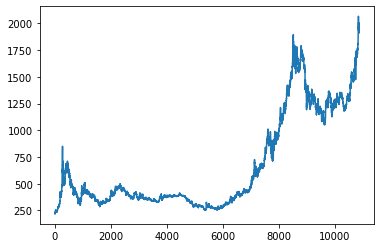

In [55]:
plt.plot(data_np[:,0],data_np[:,1])

In [24]:
data_np.

In [25]:
a.shape

(10881, 2)

In [26]:
a

array([[1.00000e+00, 2.26000e+02],
       [2.00000e+00, 2.26000e+02],
       [3.00000e+00, 2.26800e+02],
       ...,
       [1.08790e+04, 1.94720e+03],
       [1.08800e+04, 1.96625e+03],
       [1.08810e+04, 1.94740e+03]])

In [13]:
a=[[1,2,3,4,5],[6,7,8,9,10]]

In [47]:
data_np.reshape(-1,2)[:,0]

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.0879e+04, 1.0880e+04,
       1.0881e+04])

In [48]:
data_np[:,0]

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.0879e+04, 1.0880e+04,
       1.0881e+04])